<a href="https://colab.research.google.com/github/jacob7123/TensorFlow/blob/main/03_introduction_to_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.

## Get the data

The images we are working with are from the Food101 dataset(101 different classes of food): https://www.kaggle.com/datasets/dansbecker/food-101

However we have modified it to only use two classes(pizza 🍕 and steak 🥩) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

> 🔑 **Note:** we start with a smaller dataset so we can experiment quickly and figure what works(or better yet what does not work) before scaling up.

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-01-09 06:18:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   161MB/s    in 0.7s    

2024-01-09 06:18:16 (161 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data(become one with it)

A very curcil step at the beginning of any machine learning project is becoming one with data.

And for a computer vision project...this usually means visualizing many samples of your data.

In [4]:
!ls -la pizza_steak

total 16
drwxr-xr-x 4 root root 4096 Jan  9 06:18 .
drwxr-xr-x 1 root root 4096 Jan  9 06:18 ..
drwxr-xr-x 4 root root 4096 Jan  9 06:18 test
drwxr-xr-x 4 root root 4096 Jan  9 06:18 train


In [3]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.


In [6]:
# Another way to find out how many image are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically.

In [7]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)


['pizza' 'steak']


In [8]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Set the target directory(we will view images from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Reading in the image and plot it using matplot
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image
  return img

['3173779.jpg']
Image shape: (512, 512, 3)


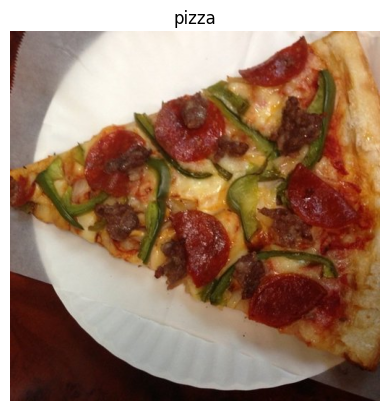

In [16]:
# View a random image from training dataset
img = view_random_image(target_dir="pizza_steak/train/",
             target_class="pizza")

In [17]:
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 62,  16,  16],
        [ 59,  15,  14],
        [ 58,  14,  15],
        ...,
        [218, 195, 177],
        [217, 191, 176],
        [214, 188, 173]],

       [[ 63,  17,  17],
        [ 62,  16,  16],
        [ 59,  15,  16],
        ...,
        [218, 195, 177],
        [218, 192, 177],
        [215, 189, 174]],

       [[ 67,  19,  17],
        [ 63,  18,  15],
        [ 60,  16,  15],
        ...,
        [218, 195, 177],
        [217, 191, 176],
        [215, 189, 174]],

       ...,

       [[ 71,  28,  22],
        [ 73,  30,  24],
        [ 73,  28,  23],
        ...,
        [ 61,  48,  42],
        [ 62,  49,  43],
        [ 62,  49,  43]],

       [[ 71,  27,  24],
        [ 71,  27,  24],
        [ 70,  25,  20],
        ...,
        [ 60,  45,  40],
        [ 61,  46,  41],
        [ 62,  47,  42]],

       [[ 70,  26,  23],
        [ 70,  26,  23],
        [ 67,  22,  17],
        ...,
        [ 56,  41,  3